Simulació d'imatges STM amb SIESTA
-----

En aquesta pràctica hem desenvolupat un codi que simula imatges STM de la molècula de benzè ($C_6H_6$).

En primer lloc, cal importar tots els paquets que usarem per fer el càlcul i les simulacions

In [1]:
from pathlib import Path
import os
import sisl
import sisl.viz
import numpy as np
from ase.build import molecule

A continuació, definirem la molècula usant un paquet de python `ase`, que ja ens dona algunes estructures determinades. Aquesta estructra és la que usarem per definir la geometria que tindrà el nostre sistema.

In [53]:
atoms = molecule('C6H6', vacuum = 5) 
benzene = sisl.Geometry.new(atoms)

Podem representar l'estructura per tal de comprovar que és tal i com esperem.

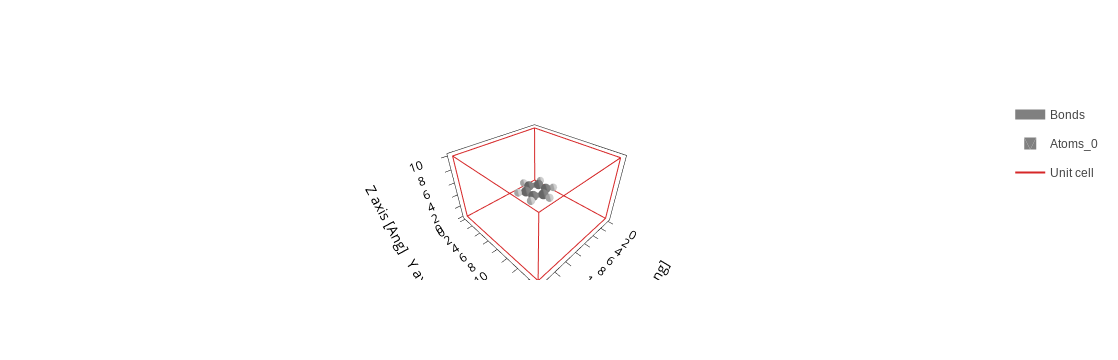

In [54]:
benzene.plot(axes='xyz') 

Ara, definim tots els directoris que usarem durant els càlculs i la simulació, tant el directori amb els arxius d'input, el directori on volem guardar els resultats com el directori on es troba `SIESTA`.

In [3]:
inputs = Path('inputs')
results = Path('results')
siesta = '/opt/anaconda3/envs/nanociencia/bin/siesta'

A continuació, creem un arxiu on hi guardem l'estructura del benzè, el nostre sistema.

In [4]:
benzene.write(inputs/'geom.fdf')

En l'arxiu de geometria que acabem de crear, hi afegim unes línies per tal que durant el càlcul de `SIESTA` ens guardi l'Hamiltonià.

In [5]:
with open(inputs/'RUN.fdf', 'w') as f:
    f.write('%include geom.fdf \n')
    f.write('TS.HS.Save true')

Amb tots els passos anterior enllestits, ja podem executar el càlcul usant `SIESTA`.

In [6]:
# Executem SIESTA per dur a terme els càlculs i obtenir els resultats
os.system(f'cd {results}; {siesta} RUN.fdf > RUN.out')

Job completed


0

In [7]:
# Llegim l'Hamiltonià després del càlcul
H = sisl.get_sile(results/"RUN.fdf").read_hamiltonian() 
# Llegim la geometria de la molècula després del càlcul
geom = sisl.get_sile(results/"RUN.fdf").read_geometry() 

In [8]:
# Busquem tots els estats propis del sistema i els afegim en una llista
eigenstates = H.eigenstate() 
eigenstates.eig

array([-16.85584921, -14.0856129 , -14.08561174, -10.53069213,
       -10.53054227,  -8.65691373,  -6.88636117,  -6.66710033,
        -5.94719358,  -5.94660128,  -4.7629345 ,  -3.947479  ,
        -3.9472216 ,  -2.0336825 ,  -2.0335716 ,   3.17039698,
         3.17043392,   6.11502598,   7.11138195,   7.63003778,
         7.63105022,   8.40580666,   8.40584601,   9.16184149,
        11.24458368,  11.24516225,  11.43573032,  11.43615096,
        11.82269438,  12.22032039,  12.44676789,  14.53391452,
        14.534041  ,  15.05254152,  15.05304262,  15.49873408,
        16.05283721,  16.05462092,  16.98877124,  17.24325958,
        17.47766281,  17.47772598,  18.04618741,  19.26995222,
        19.89849062,  21.96329687,  21.96476612,  22.06533538,
        22.06778255,  22.08878172,  22.08900384,  23.82259741,
        23.82262539,  24.69043576,  24.9404016 ,  24.94327857,
        25.9243249 ,  26.8633256 ,  26.8666338 ,  27.21287037,
        27.50885201,  28.22176221,  28.22599683,  29.59

In [48]:
# Definim una nova funció amb la qual podrem representar la imatge STM
def LDOS_grid(H, V): 
    # Creem un grid principal on anirem axumulant les densitats d'estats
    grida = sisl.Grid((100, 100, 100), geometry=geom) 
    eigenstates = H.eigenstate()
    # Creem un grid secundari on per ana-lo utilitzant de manera temporal en cada iteració el bucle
    gridb = sisl.Grid((100, 100, 100), geometry=geom) 
    # Creem un bucle que anirà calclant per cadascun dels valors d'estats propis
    for i in eigenstates:
        # Definim els límits inferior i superior de càlcul per valors positius
        if V > 0:
            if i.eig >=0 and i.eig <= V: 
                # Definim com a 0 el grid secundari abans de tornar a fer una iteració de cada bucle
                gridb.fill(0) 
                # Calculem la funció d'ona per cadascun dels estats propis
                wf = i.wavefunction(gridb) 
                # Calculem la densitat d'estats elevant als quadrats la funció d'ona en cada punt de la malla
                square = gridb * gridb
                # Sumem cadascuna de les densitats d'estats per obtenir la imatge final
                grida = grida + square 
        # Definim els límits inferior i superior de càlcul per valors negatius
        elif V < 0:
            if i.eig >= V and i.eig <= 0: 
                # Definim com a 0 el grid secundari abans de tornar a fer una iteració de cada bucle
                gridb.fill(0) 
                # Calculem la funció d'ona per cadascun dels estats propis
                wf = i.wavefunction(gridb) 
                # Calculem la densitat d'estats elevant als quadrats la funció d'ona en cada punt de la malla
                square = gridb * gridb
                # Sumem cadascuna de les densitats d'estats per obtenir la imatge final
                grida = grida + square 
    # Obtenim la imatge final
    return grida 

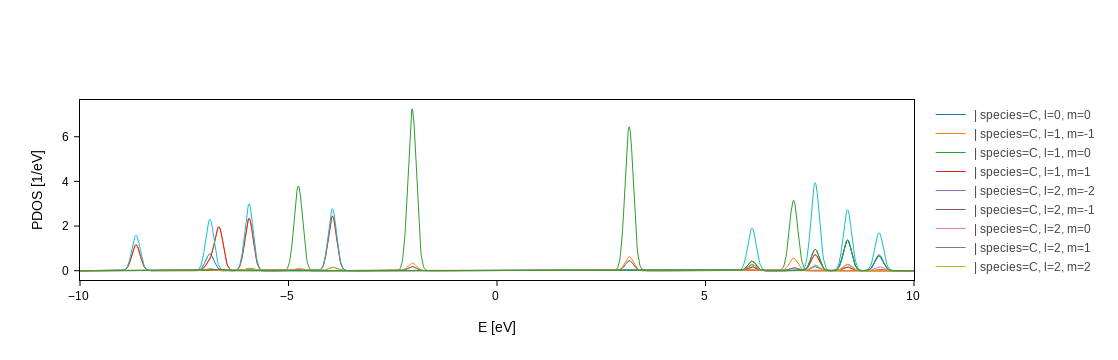

In [30]:
# Representem la densitat d'estats per comprovar els valors de voltatge als que apareixen orbitals
H.plot.pdos(data_Erange=[-10, 10], nE=1200, Erange=[-10, 10], kgrid=[1,1,1]).split_DOS(on="species+l+m") 

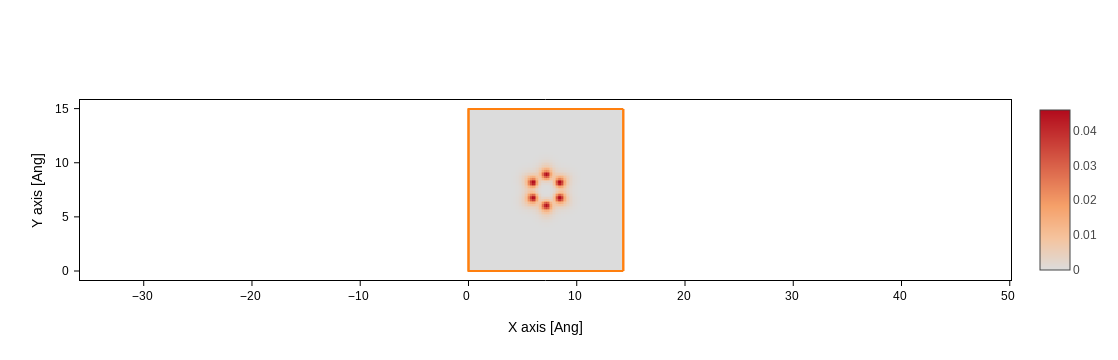

In [51]:
# Definim la variable de voltatge
V = 5
# Representam el grid principal per veure la imatge STM
LDOS_grid(H, V).plot(axes='xy') 